<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/Baseline%20%26%20Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to google

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# save_model_path = '/content/drive/MyDrive/DL for VR/Project/Models' # Thomas
#save_model_path = '/content/drive/MyDrive/Deep_Learning_Visual_Recognition/Project/' # Morten
save_model_path = '/content/drive/MyDrive/Visual reg' # Mads


Mounted at /content/drive


In [2]:
!git clone https://github.com/mortgad/DLVR.git
%cd DLVR

Cloning into 'DLVR'...
remote: Enumerating objects: 523, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 523 (delta 104), reused 72 (delta 70), pack-reused 384 (from 1)
Receiving objects: 100% (523/523), 63.10 MiB | 43.48 MiB/s, done.
Resolving deltas: 100% (290/290), done.
/content/DLVR


In [3]:
from utils.utkface import load_utkface
load_utkface()

from utils.utkface import preprocess_utkface
df_utkface, df_utkface_raw = preprocess_utkface()

Extracted part3.tar.gz
Extracted part2.tar.gz
Extracted part1.tar.gz
Deleted: /content/extracted/part3/44_1_4_20170116235150272.pg
Deleted: /content/extracted/part3/55_0_0_20170116232725357jpg
Deleted: /content/extracted/part3/.DS_Store
Deleted: /content/extracted/part1/61_3_20170109150557335.jpg
Deleted: /content/extracted/part1/61_1_20170109142408075.jpg
Deleted: /content/extracted/part2/39_1_20170116174525125.jpg
Deleted: /content/extracted/part2/53__0_20170116184028385.jpg
Deleted: /content/extracted/part3/24_0_1_20170116220224657 .jpg
Processing from: /content/extracted/part1
Processing from: /content/extracted/part2
Processing from: /content/extracted/part3


# Get data for modelling


In [4]:
df_utkface_raw.head()

,file,age_raw,gender_code,race_code,age,age_code,gender,race
0,/content/extracted/part1/53_0_0_20170104211506...,53,0,0,50-59,6,Male,White
1,/content/extracted/part1/65_1_0_20170110143540...,65,1,0,60-69,7,Female,White
2,/content/extracted/part1/5_1_0_201701091939578...,5,1,0,3-9,1,Female,White
3,/content/extracted/part1/9_0_0_201701102205157...,9,0,0,3-9,1,Male,White
4,/content/extracted/part1/4_1_2_201612191417509...,4,1,2,3-9,1,Female,Asian


In [5]:
# Drop not needed colums:
df = df_utkface_raw[['age_raw','gender_code','race_code','file']]

df = df[df['age_raw']<=100]

df.rename(columns={'age_raw': 'age_code'}, inplace=True)
#df['age_code'] = df['age_code'].astype(float)
# df.rename(columns={'gender': 'gender_code'}, inplace=True)
# df.rename(columns={'race': 'race_code'}, inplace=True)

In [6]:
from utils.preprocessing import create_lists

images, ages, races, genders = create_lists(df)
print(f"Loaded {len(images)} images.")

# Number of classes for target variable
num_classes_age = len(set(ages))
num_classes_gender = len(set(genders))
num_classes_ethnicity = len(set(races))
print(f"Number of age classes: {num_classes_age}")
print(f"Number of gender classes: {num_classes_gender}")
print(f"Number of ethnicity classes: {num_classes_ethnicity}")

Processing images:   0%|          | 0/24079 [00:00<?, ?it/s]

Loaded 24079 images.
Number of age classes: 97
Number of gender classes: 2
Number of ethnicity classes: 5


In [7]:
from sklearn.model_selection import train_test_split
from keras.applications.resnet_v2 import preprocess_input

images_preprocessed = preprocess_input(images)

# Split into train (80%) and temp (20%)
X_train, X_temp, y_train_age, y_temp_age, y_train_races, y_temp_races, y_train_gender, y_temp_gender = train_test_split(images_preprocessed, ages, races, genders, test_size=0.20, random_state=42, stratify=ages)

# Split temp into validation (75% of temp, which is 15% of original data) and test (25% of temp, which is 5% of original data)
X_val, X_test, y_val_age, y_test_age, y_val_races, y_test_races, y_val_gender, y_test_gender = train_test_split(X_temp, y_temp_age, y_temp_races, y_temp_gender, test_size=0.25, random_state=42)


print(f"Training set: {X_train.shape}, Training labels: {y_train_age.shape}")
print(f"Age validation set: {X_val.shape}, Age validation labels: {y_val_age.shape}")
print(f"Age test set: {X_test.shape}, Age test labels: {y_test_age.shape}")
print(f"Race validation labels: {y_val_races.shape}")
print(f"Race test labels: {y_test_races.shape}")
print(f"Gender validation labels: {y_val_gender.shape}")
print(f"Gender test labels: {y_test_gender.shape}")

Training set: (19263, 224, 224, 3), Training labels: (19263,)
Age validation set: (3612, 224, 224, 3), Age validation labels: (3612,)
Age test set: (1204, 224, 224, 3), Age test labels: (1204,)
Race validation labels: (3612,)
Race test labels: (1204,)
Gender validation labels: (3612,)
Gender test labels: (1204,)


# Training baseline model

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 686.0565 - mae: 20.6587
Epoch 1: val_mae improved from inf to 12.23808, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 286s 469ms/step - loss: 686.0565 - mae: 20.6587 - val_loss: 242.5660 - val_mae: 12.2381
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 191.4489 - mae: 10.4950
Epoch 2: val_mae improved from 12.23808 to 8.80968, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 276s 458ms/step - loss: 191.4489 - mae: 10.4950 - val_loss: 151.0961 - val_mae: 8.8097
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 138.5741 - mae: 8.6830
Epoch 3: val_mae improved from 8.80968 to 8.42727, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline.keras
602/602 [==============================] - 277s 461ms/step - 

Best Training MAE: 5.0092
Best Validation MAE: 7.6974
Best Training Loss: 44.8473
Best Validation Loss: 125.4419


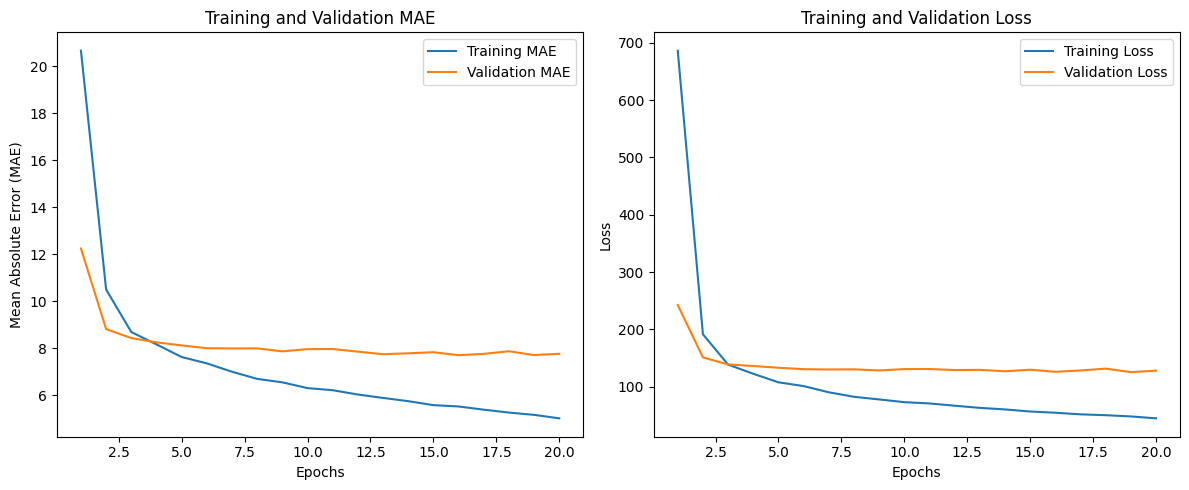

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

In [ ]:
def evaluate_and_plot_regression(history, mae_key='mae', val_mae_key='val_mae', loss_key='loss', val_loss_key='val_loss'):
    import matplotlib.pyplot as plt
    # Get the MAE and loss data from the history object
    mae = history.history[mae_key]
    val_mae = history.history[val_mae_key]
    loss = history.history[loss_key]
    val_loss = history.history[val_loss_key]
    epochs = range(1, len(mae) + 1)

    # Find the best MAE and loss values
    best_mae = min(mae)  # Lower MAE is better
    best_val_mae = min(val_mae)
    best_loss = min(loss)
    best_val_loss = min(val_loss)

    # Print the best values
    print(f"Best Training MAE: {best_mae:.4f}")
    print(f"Best Validation MAE: {best_val_mae:.4f}")
    print(f"Best Training Loss: {best_loss:.4f}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # Plotting MAE
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, val_mae, label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Baseline with lower learning rate

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline_lower_learningRate.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 1370.7603 - mae: 31.8758
Epoch 1: val_mae improved from inf to 30.58118, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learningRate.keras
602/602 [==============================] - 289s 472ms/step - loss: 1370.7603 - mae: 31.8758 - val_loss: 1268.3475 - val_mae: 30.5812
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 1245.2206 - mae: 30.2779
Epoch 2: val_mae improved from 30.58118 to 28.90047, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learningRate.keras
602/602 [==============================] - 285s 473ms/step - loss: 1245.2206 - mae: 30.2779 - val_loss: 1138.5598 - val_mae: 28.9005
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 1111.4092 - mae: 28.4728
Epoch 3: val_mae improved from 28.90047 to 27.08019, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learningRat

Best Training MAE: 8.2902
Best Validation MAE: 7.9635
Best Training Loss: 126.7804
Best Validation Loss: 123.6114


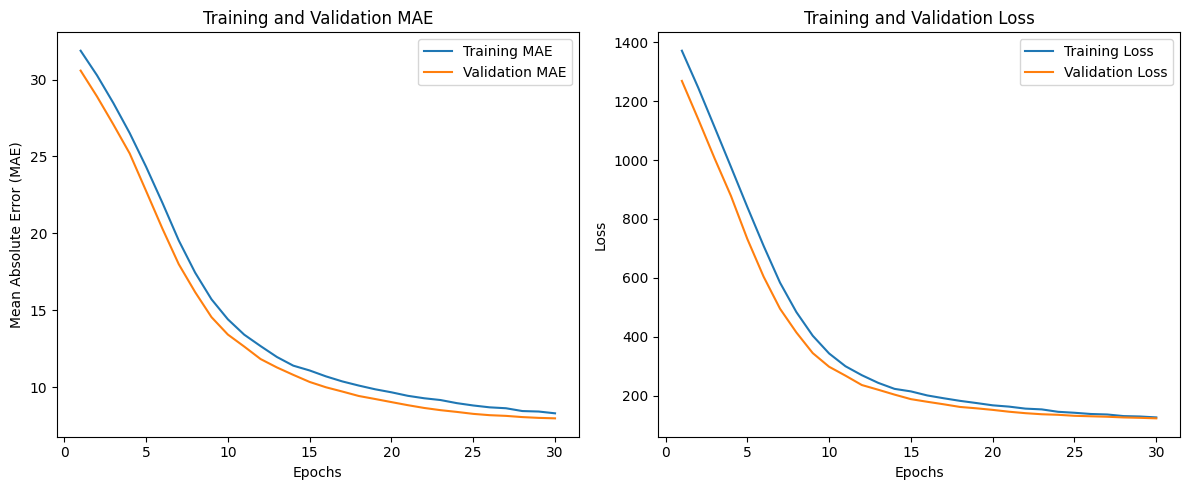

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Baseline more Epochs low learningrate


In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline_lower_learningRate_60.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=60,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/60
602/602 [==============================] - ETA: 0s - loss: 1454.2355 - mae: 32.7218
Epoch 1: val_mae improved from inf to 32.12778, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learningRate_60.keras
602/602 [==============================] - 288s 471ms/step - loss: 1454.2355 - mae: 32.7218 - val_loss: 1389.5637 - val_mae: 32.1278
Epoch 2/60
602/602 [==============================] - ETA: 0s - loss: 1320.6906 - mae: 31.4132
Epoch 2: val_mae improved from 32.12778 to 30.29621, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learningRate_60.keras
602/602 [==============================] - 283s 470ms/step - loss: 1320.6906 - mae: 31.4132 - val_loss: 1215.8564 - val_mae: 30.2962
Epoch 3/60
602/602 [==============================] - ETA: 0s - loss: 1141.1172 - mae: 29.2824
Epoch 3: val_mae improved from 30.29621 to 27.89684, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_lower_learn

Best Training MAE: 7.0914
Best Validation MAE: 7.9610
Best Training Loss: 90.4870
Best Validation Loss: 127.1244


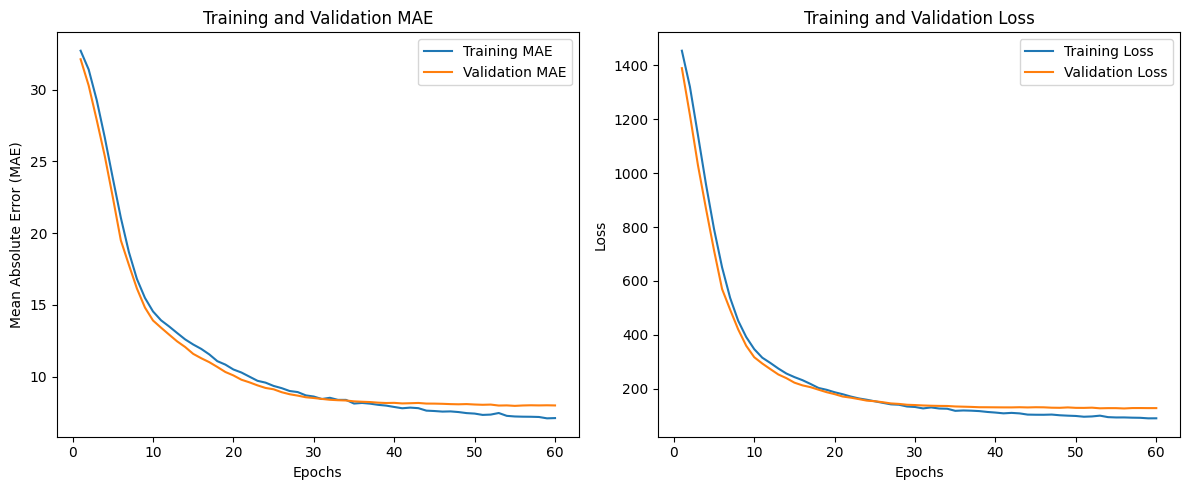

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Baseline middel learning rate

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_baseline_middel_learningRate_40.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/40
602/602 [==============================] - ETA: 0s - loss: 1413.2957 - mae: 32.2633
Epoch 1: val_mae improved from inf to 31.06947, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_middel_learningRate_40.keras
602/602 [==============================] - 285s 467ms/step - loss: 1413.2957 - mae: 32.2633 - val_loss: 1296.3756 - val_mae: 31.0695
Epoch 2/40
602/602 [==============================] - ETA: 0s - loss: 1213.0393 - mae: 29.9747
Epoch 2: val_mae improved from 31.06947 to 27.88136, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_middel_learningRate_40.keras
602/602 [==============================] - 281s 467ms/step - loss: 1213.0393 - mae: 29.9747 - val_loss: 1042.4973 - val_mae: 27.8814
Epoch 3/40
602/602 [==============================] - ETA: 0s - loss: 973.2459 - mae: 26.7072
Epoch 3: val_mae improved from 27.88136 to 24.53109, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_baseline_middel_lea

Best Training MAE: 7.0096
Best Validation MAE: 7.6822
Best Training Loss: 88.2273
Best Validation Loss: 118.9001


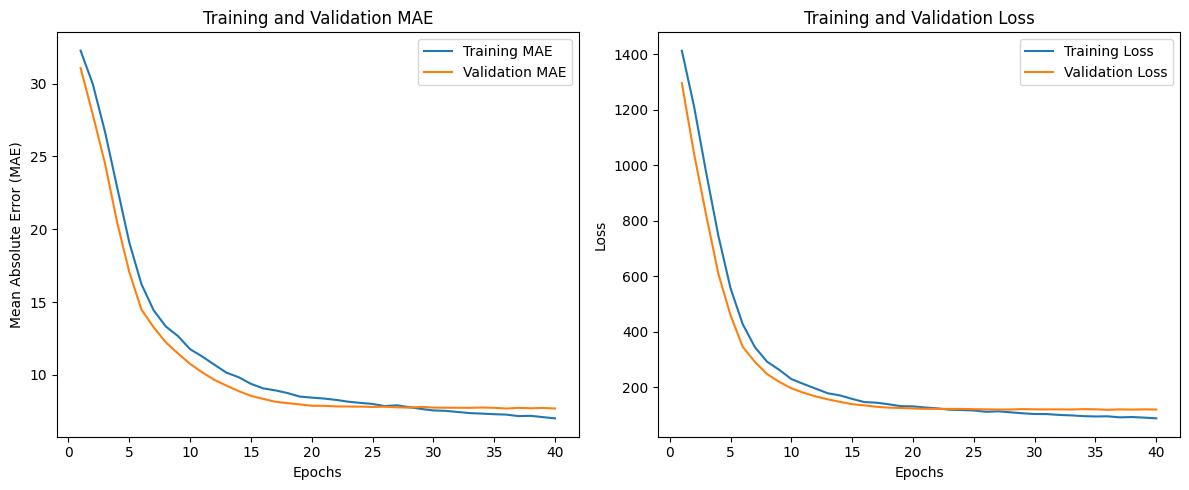

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Cyclical Learning Rate

## Base-model

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

print("Conv base, training, and validation sets have been created...")

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Conv base, training, and validation sets have been created...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   


## Learning Rate Range

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

class LearningRateFinder(Callback):
    def __init__(self, min_lr=1e-6, max_lr=1e-3, steps_per_epoch=None, epochs=1):
        super().__init__()
        self.min_lr = min_lr  # Starting learning rate
        self.max_lr = max_lr  # Ending learning rate
        if steps_per_epoch is None:
            raise ValueError("steps_per_epoch must be set")
        self.total_steps = steps_per_epoch * epochs  # Total number of steps (batches)
        self.batch_num = 0
        self.learning_rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        self.batch_num += 1
        logs = logs or {}
        # Compute the new learning rate
        lr = self.min_lr + (((self.max_lr - self.min_lr) * self.batch_num) / self.total_steps)

        # Use assign to directly update the learning rate attribute
        self.model.optimizer.learning_rate.assign(lr)  # Use assign instead of set_value

        # Log the learning rate and loss
        self.learning_rates.append(lr)
        self.losses.append(logs.get('loss'))

        # Optionally, stop training if loss diverges
        if logs.get('loss') is not None and (tf.math.is_nan(logs.get('loss')) or tf.math.is_inf(logs.get('loss'))):
            self.model.stop_training = True
            print("Stopping training due to loss divergence")

# Plot function for learning rate vs. loss
def plot_lr_vs_loss(lr_finder):
    plt.figure(figsize=(8, 6))
    plt.plot(lr_finder.learning_rates, lr_finder.losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate vs. Loss')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 32
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
initial_learning_rate=1e-7
max_learning_rate=1e-2

### Learning rate finder
lr_finder = LearningRateFinder(min_lr=initial_learning_rate, max_lr=max_learning_rate, steps_per_epoch=steps_per_epoch, epochs=1)

### Checkpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'lr_range_resnet50v2_model_baseline.keras'
# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

### Compile
# Compile the model again with the initial learning rate
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss="mean_squared_error",
              optimizer=optimizer,
              metrics=["mae"])

# Train the model using the Learning Rate Finder
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=1,  # For learning rate finder, use only one epoch
    batch_size=batch_size,
    callbacks=[lr_finder],
    validation_data=(X_val, y_val_age),
    verbose=1
)

602/602 [==============================] - 288s 471ms/step - loss: 333.9443 - mae: 12.8745 - val_loss: 232.3829 - val_mae: 11.3928


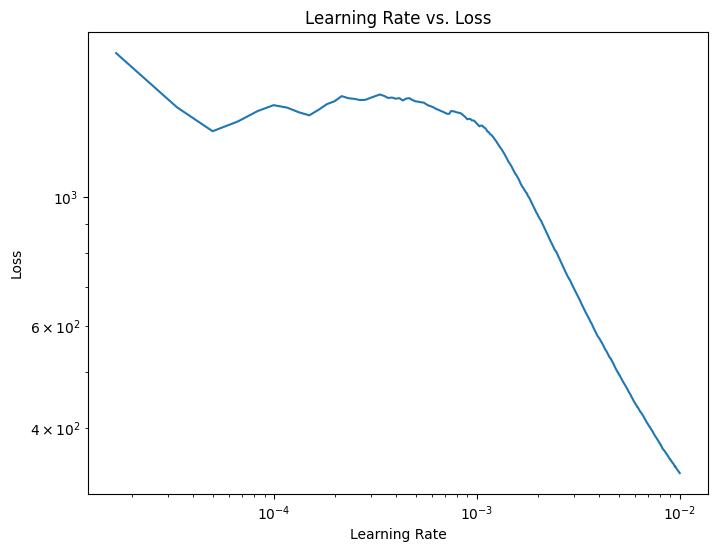

In [ ]:
# Plot the learning rate vs. loss
plot_lr_vs_loss(lr_finder)

## Cyclical Learning Rate

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

# Define a cyclic learning rate function
class CyclicLearningRate(Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-3, step_size=2000, mode='triangular'):
        super(CyclicLearningRate, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.lr_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.lr_iterations / (2 * self.step_size))
        x = np.abs(self.lr_iterations / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x))
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
        elif self.mode == 'exp_range':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, (1 - x)) * (0.99994 ** self.lr_iterations)

    def on_train_batch_begin(self, batch, logs=None):
        self.lr_iterations += 1
        new_lr = self.clr()
        self.model.optimizer.lr.assign(new_lr)
        self.history.setdefault('lr', []).append(new_lr)
        self.history.setdefault('iterations', []).append(self.lr_iterations)


### Triangular

In [ ]:
# Model compilation
model.compile(
    optimizer=AdamW(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mae']
)

# Initialize the cyclic learning rate scheduler
clr = CyclicLearningRate(base_lr=1e-4, max_lr=1e-2, step_size=2000, mode='triangular')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    validation_data=(X_val, y_val_age),
    epochs=20,
    batch_size=32,
    callbacks=[clr]
)

Epoch 1/20
602/602 [==============================] - 276s 452ms/step - loss: 423.1946 - mae: 14.5060 - val_loss: 163.7070 - val_mae: 9.4068
Epoch 2/20
602/602 [==============================] - 275s 457ms/step - loss: 154.5276 - mae: 8.9431 - val_loss: 138.7074 - val_mae: 8.1199
Epoch 3/20
602/602 [==============================] - 274s 454ms/step - loss: 141.7526 - mae: 8.5298 - val_loss: 128.1702 - val_mae: 7.6621
Epoch 4/20
602/602 [==============================] - 271s 450ms/step - loss: 134.3384 - mae: 8.3263 - val_loss: 228.5090 - val_mae: 10.8654
Epoch 5/20
602/602 [==============================] - 273s 453ms/step - loss: 117.5485 - mae: 7.7753 - val_loss: 119.2033 - val_mae: 7.7085
Epoch 6/20
602/602 [==============================] - 276s 458ms/step - loss: 98.1369 - mae: 7.1342 - val_loss: 113.3804 - val_mae: 7.2926
Epoch 7/20
602/602 [==============================] - 274s 456ms/step - loss: 81.9060 - mae: 6.5305 - val_loss: 108.3131 - val_mae: 7.2055
Epoch 8/20
602/602 [

Best Training MAE: 5.7869
Best Validation MAE: 6.8976
Best Training Loss: 62.5895
Best Validation Loss: 108.0671


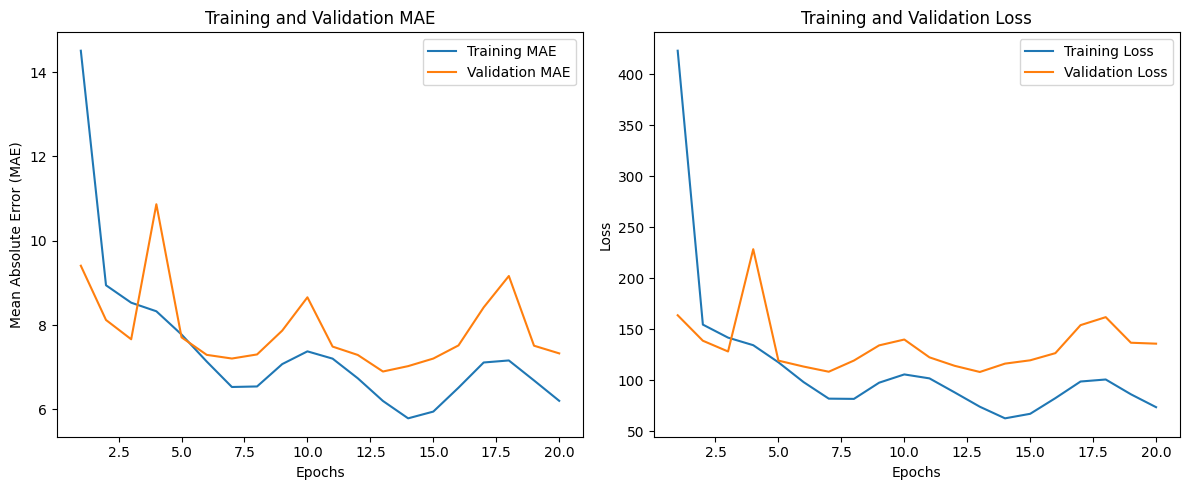

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

### Triangular decay

In [ ]:
# Model compilation
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mean_squared_error',
    metrics=['mae']
)

# Initialize the cyclic learning rate scheduler
clr = CyclicLearningRate(base_lr=1e-3, max_lr=1e-2, step_size=2000, mode='exp_range')

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    validation_data=(X_val, y_val_age),
    epochs=30,
    batch_size=32,
    callbacks=[clr]
)

Epoch 1/30
602/602 [==============================] - 288s 471ms/step - loss: 260.4464 - mae: 11.5783 - val_loss: 198.9869 - val_mae: 9.5994
Epoch 2/30
602/602 [==============================] - 284s 471ms/step - loss: 149.9272 - mae: 8.8241 - val_loss: 124.0741 - val_mae: 7.9343
Epoch 3/30
602/602 [==============================] - 284s 471ms/step - loss: 138.7077 - mae: 8.4738 - val_loss: 134.0202 - val_mae: 8.4378
Epoch 4/30
602/602 [==============================] - 283s 470ms/step - loss: 129.5469 - mae: 8.1582 - val_loss: 125.4825 - val_mae: 8.1237
Epoch 5/30
602/602 [==============================] - 283s 471ms/step - loss: 111.7748 - mae: 7.5545 - val_loss: 126.2190 - val_mae: 7.5296
Epoch 6/30
602/602 [==============================] - 284s 472ms/step - loss: 93.2733 - mae: 6.9350 - val_loss: 111.7479 - val_mae: 7.2537
Epoch 7/30
602/602 [==============================] - 285s 473ms/step - loss: 77.8628 - mae: 6.4130 - val_loss: 112.5163 - val_mae: 7.2354
Epoch 8/30
602/602 [=

Best Training MAE: 4.6005
Best Validation MAE: 7.0859
Best Training Loss: 38.9322
Best Validation Loss: 108.5021


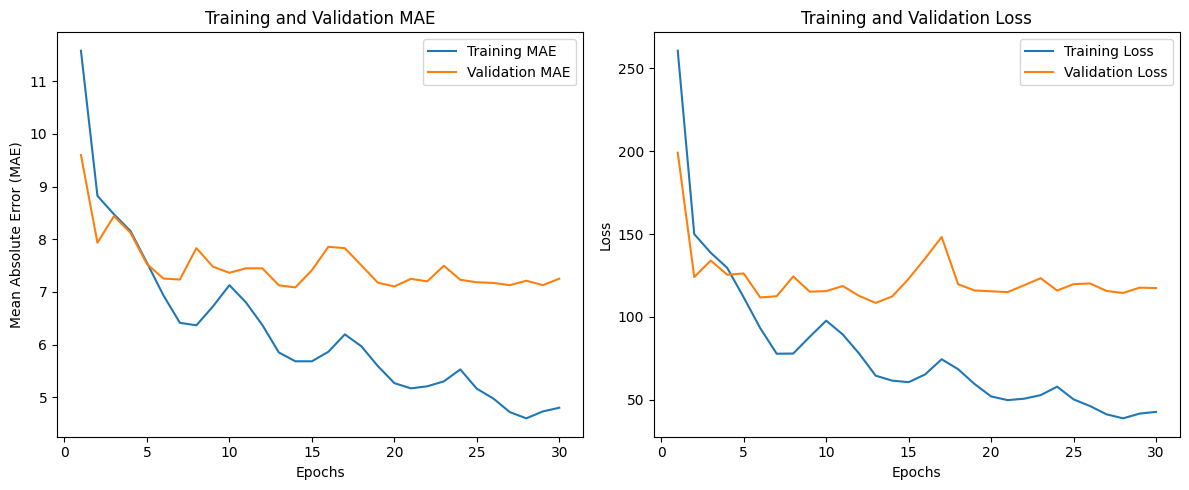

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Training Multitask model


In [ ]:
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np
input_shape = images[0].shape

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape,
)
conv_base.trainable = False  # Freeze the pre-trained layers


# Create the new model using ResNet50V2 as the base
inputs = keras.Input(input_shape)
# x = keras.applications.resnet_v2.preprocess_input(inputs) # <----- images er allerede preprocessed
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
age = layers.Dense(512, activation='relu')(x)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.3)(age)
age = layers.Dense(256, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dense(128, activation='relu')(age)
age = layers.BatchNormalization()(age)
age = layers.Dropout(0.2)(age)
age = layers.Dense(64, activation='relu')(age)
age = layers.Dense(1, activation='linear', name='age_output')(age)
gender = layers.Dense(256, activation='relu')(x)
gender = layers.BatchNormalization()(gender)
gender = layers.Dropout(0.2)(gender)
gender = layers.Dense(128, activation='relu')(gender)
gender = layers.Dense(num_classes_gender, activation="softmax", name='gender_output')(gender)
#race = layers.Dense(512, activation='relu')(x)
#race = layers.BatchNormalization()(race)
#race = layers.Dropout(0.3)(race)
#race = layers.Dense(256, activation='relu')(race)
#race = layers.BatchNormalization()(race)
#race = layers.Dropout(0.2)(race)
#race = layers.Dense(128, activation='relu')(race)
#race = layers.BatchNormalization()(race)
#race = layers.Dense(64, activation='relu')(race)
#race = layers.Dense(num_classes_ethnicity, activation="softmax", name='race_output')(race)
multitask_model = keras.Model(inputs=inputs, outputs=[age, gender]) # Race deleted
multitask_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50v2 (Functional)     (None, 7, 7, 2048)           2356480   ['input_5[0][0]']             
                                                          0                                       
                                                                                                  
 global_average_pooling2d_1  (None, 2048)                 0         ['resnet50v2[0][0]']          
  (GlobalAveragePooling2D)                                                                        
                                                                                            

In [ ]:
# Define num_classes_gender and num_classes_ethnicity
#num_classes_gender = 2  # Adjust based on your dataset
#num_classes_ethnicity = 5  # Adjust based on your dataset

optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# Compile the model with weighted losses
multitask_model.compile(
    optimizer=optimizer,
    loss={
        "age_output": "mean_squared_error",
        "gender_output": "sparse_categorical_crossentropy"
    },
    metrics={
        "age_output": ["mae"],
        "gender_output": ["accuracy"]
    },
    # Specify the weights for each loss function
    loss_weights={
        "age_output": 0.6,
        "gender_output": 0.4
    }
)

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = save_model_path
model_name = 'resnet50v2_model_multitask.keras'

# Define ModelCheckpoint callback to monitor gender or race accuracy, or age mae
multitask_checkpoint = ModelCheckpoint(
    file_path + model_name,
    monitor='val_age_output_mae',  # Adjust as needed
    verbose=1,
    save_best_only=True,
    mode='max'
)


In [ ]:
# Train the model
multitask_history = multitask_model.fit(
    X_train,
    [y_train_age, y_train_gender],
    epochs=50,
    batch_size=64,
    validation_data=(X_val, [y_val_age, y_val_gender]),
    callbacks=[multitask_checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 805.1331 - age_output_loss: 804.3367 - gender_output_loss: 0.7967 - age_output_mae: 22.1121 - gender_output_accuracy: 0.5117
Epoch 1: val_age_output_mae improved from -inf to 15.58174, saving model to /content/drive/MyDrive/Visual regresnet50v2_model_multitask.keras
602/602 [==============================] - 922s 2s/step - loss: 805.1331 - age_output_loss: 804.3367 - gender_output_loss: 0.7967 - age_output_mae: 22.1121 - gender_output_accuracy: 0.5117 - val_loss: 434.7342 - val_age_output_loss: 434.0335 - val_gender_output_loss: 0.7006 - val_age_output_mae: 15.5817 - val_gender_output_accuracy: 0.5177
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 407.9384 - age_output_loss: 407.2105 - gender_output_loss: 0.7278 - age_output_mae: 15.5606 - gender_output_accuracy: 0.5035
Epoch 2: val_age_output_mae did not improve from 15.58174
602/602 [==============================] - 894s 1s/step - loss: 407.

KeyboardInterrupt: 

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression
from utils.preprocessing import evaluate_and_plot_classifier

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)
print("########## Age ##########")
evaluate_and_plot_regression(multitask_history, 'age_output_mae', 'val_age_output_mae', 'age_output_loss', 'val_age_output_loss')
print("\n########## Gender ##########")
evaluate_and_plot_classifier(multitask_history, 'gender_output_accuracy', 'val_gender_output_accuracy', 'gender_output_loss', 'val_gender_output_loss')

# Data augmentation


In [ ]:
# Define data augmentation:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1)
])

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))

x = data_augmentation(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_15 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 512)               1049

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_dropout.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 743.5830 - mae: 21.3585
Epoch 1: val_mae improved from inf to 10.48877, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 283s 463ms/step - loss: 743.5830 - mae: 21.3585 - val_loss: 205.0775 - val_mae: 10.4888
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 212.8786 - mae: 10.8947
Epoch 2: val_mae improved from 10.48877 to 9.49402, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 275s 457ms/step - loss: 212.8786 - mae: 10.8947 - val_loss: 171.6758 - val_mae: 9.4940
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 194.2006 - mae: 10.2951
Epoch 3: val_mae improved from 9.49402 to 9.15173, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 276s 459ms/step - lo

Best Training MAE: 8.2607
Best Validation MAE: 8.6532
Best Training Loss: 128.2061
Best Validation Loss: 155.6714


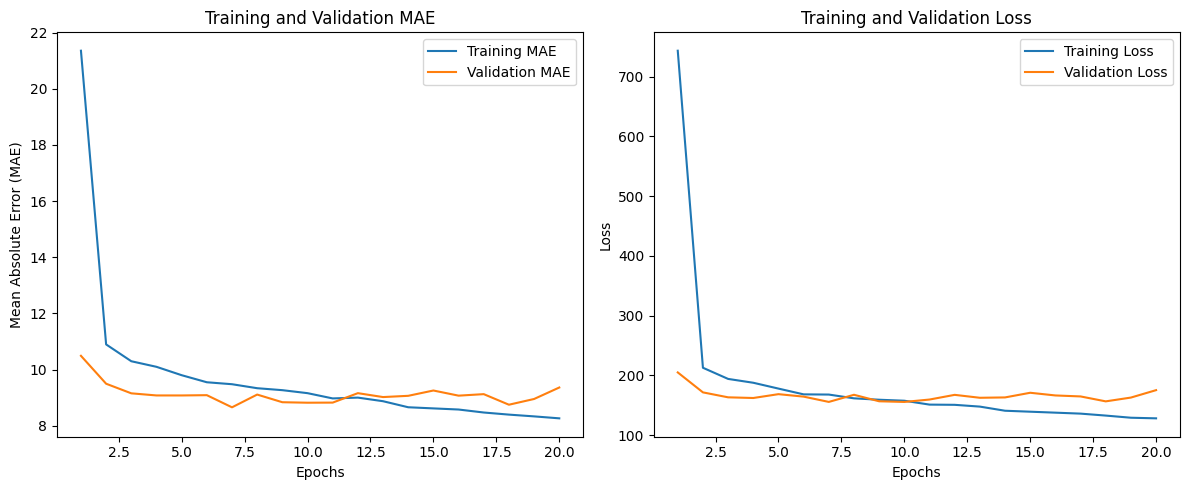

In [ ]:
evaluate_and_plot(resnet_history)

# Less augmentation

In [ ]:
# Define data augmentation:
from tensorflow import keras
from tensorflow.keras import layers


data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))

x = data_augmentation(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_12 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 512)               1049

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_dropout.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 898.3825 - mae: 24.4903
Epoch 1: val_mae improved from inf to 12.71930, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 275s 447ms/step - loss: 898.3825 - mae: 24.4903 - val_loss: 272.9116 - val_mae: 12.7193
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 233.1433 - mae: 11.5152
Epoch 2: val_mae improved from 12.71930 to 8.76811, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 256s 426ms/step - loss: 233.1433 - mae: 11.5152 - val_loss: 138.8380 - val_mae: 8.7681
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 166.3568 - mae: 9.5011
Epoch 3: val_mae improved from 8.76811 to 8.44776, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_dropout.keras
602/602 [==============================] - 254s 421ms/step - los

Best Training MAE: 7.3334
Best Validation MAE: 7.4816
Best Training Loss: 101.9451
Best Validation Loss: 110.0885


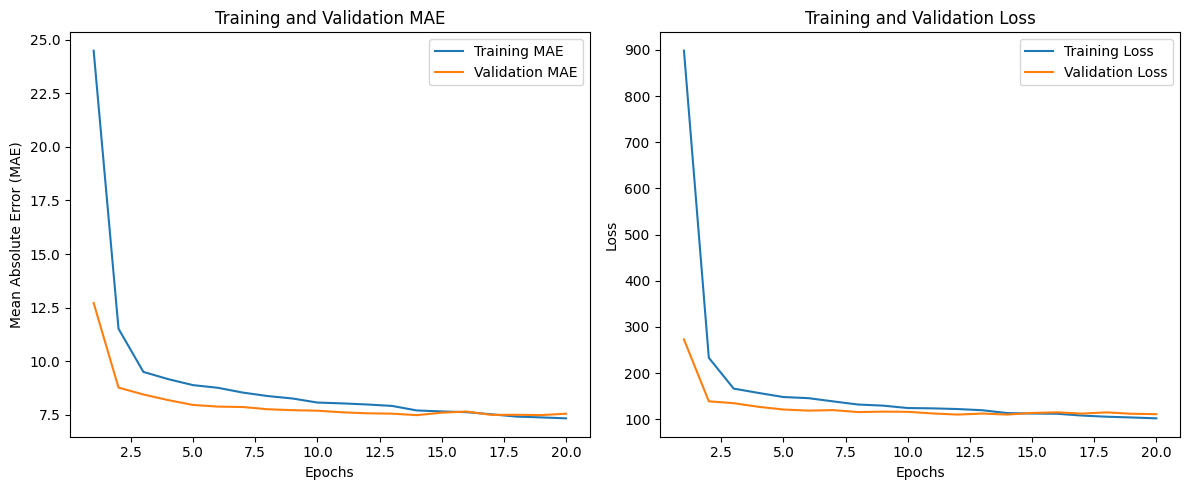

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Fine-tuning


## Block 5

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow import keras

# Now proceed with the ResNet50V2 model using the preprocessed images
conv_base = ResNet50V2(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = True

# Find the index of 'conv4_block6_out'
layer_name = 'conv4_block6_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv4_block6_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv4_block6_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

94668760/94668760 [==============================] - 0s 0us/step
Found layer 'conv4_block6_out' at index 153
Layer 0: input_1, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_relu, Trainable: False
Layer 19: conv2_block2_1_conv, 

In [ ]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048  

In [ ]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_finetune_block_5.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/20
602/602 [==============================] - ETA: 0s - loss: 1398.5415 - mae: 32.3891
Epoch 1: val_mae improved from inf to 31.03643, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==============================] - 403s 662ms/step - loss: 1398.5415 - mae: 32.3891 - val_loss: 1243.3777 - val_mae: 31.0364
Epoch 2/20
602/602 [==============================] - ETA: 0s - loss: 1104.0143 - mae: 28.9906
Epoch 2: val_mae improved from 31.03643 to 26.56076, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==============================] - 396s 659ms/step - loss: 1104.0143 - mae: 28.9906 - val_loss: 924.7162 - val_mae: 26.5608
Epoch 3/20
602/602 [==============================] - ETA: 0s - loss: 871.4423 - mae: 25.6012
Epoch 3: val_mae improved from 26.56076 to 22.72719, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5.keras
602/602 [==================

Best Training MAE: 5.9783
Best Validation MAE: 7.0483
Best Training Loss: 61.8267
Best Validation Loss: 101.8201


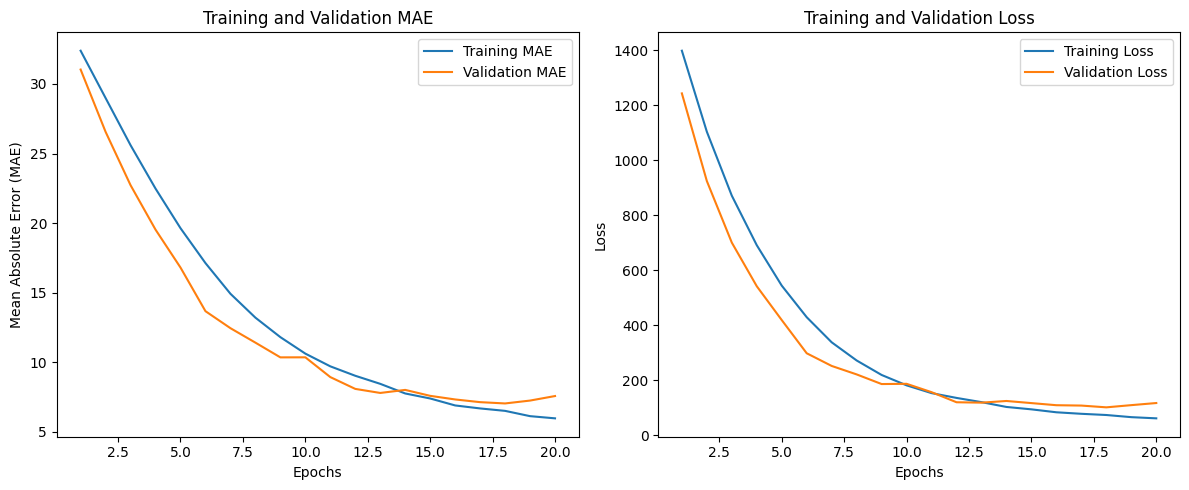

In [ ]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

## Block 5+4

In [8]:
from keras.applications.resnet_v2 import preprocess_input
from keras.applications import ResNet50V2
import keras
from keras import layers, models
import numpy as np

# Assume 'images_preprocessed' is already defined and contains your preprocessed images
input_shape = (
    images_preprocessed[0].shape[0],
    images_preprocessed[0].shape[1],
    images_preprocessed[0].shape[2]
)

# Load the ResNet50V2 model
conv_base = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)
conv_base.trainable = True

# Reset all layers to non-trainable
for layer in conv_base.layers:
    layer.trainable = False

# Find the index of 'conv3_block4_out'
layer_name = 'conv3_block4_out'
layer_index = None

for idx, layer in enumerate(conv_base.layers):
    if layer.name == layer_name:
        layer_index = idx
        print(f"Found layer '{layer_name}' at index {layer_index}")
        break

if layer_index is None:
    raise ValueError(f"Layer '{layer_name}' not found in conv_base.")

# Freeze all layers before and including 'conv3_block4_out'
for layer in conv_base.layers[:layer_index + 1]:
    layer.trainable = False

# Unfreeze all layers after 'conv3_block4_out'
for layer in conv_base.layers[layer_index + 1:]:
    layer.trainable = True

# Freeze all BatchNormalization layers
for layer in conv_base.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False

# Verify the trainable status
print("\nTrainable status after processing 'conv3_block4_out':")
for idx, layer in enumerate(conv_base.layers):
    print(f"Layer {idx}: {layer.name}, Trainable: {layer.trainable}")

94668760/94668760 [==============================] - 0s 0us/step
Found layer 'conv3_block4_out' at index 85

Trainable status after processing 'conv3_block4_out':
Layer 0: input_1, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: pool1_pad, Trainable: False
Layer 4: pool1_pool, Trainable: False
Layer 5: conv2_block1_preact_bn, Trainable: False
Layer 6: conv2_block1_preact_relu, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_pad, Trainable: False
Layer 11: conv2_block1_2_conv, Trainable: False
Layer 12: conv2_block1_2_bn, Trainable: False
Layer 13: conv2_block1_2_relu, Trainable: False
Layer 14: conv2_block1_0_conv, Trainable: False
Layer 15: conv2_block1_3_conv, Trainable: False
Layer 16: conv2_block1_out, Trainable: False
Layer 17: conv2_block2_preact_bn, Trainable: False
Layer 18: conv2_block2_preact_

In [9]:
# Create the new model using ResNet50V2 as the base
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
from tensorflow.keras import layers

x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)  # Dropout with a 50% rate

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Dropout with a 40% rate

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu')(x)

# Adjust the output layer for age prediction
outputs = layers.Dense(1, activation='linear')(x)  # Single neuron for numeric output

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048  

In [10]:
# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="mean_squared_error",  # Use MSE or MAE for regression
              optimizer=optimizer,
              metrics=["mae"])  # Optionally use MAE as a metric

# Define the callback for saving the best model
from tensorflow.keras.callbacks import ModelCheckpoint
file_path = '/content/drive/MyDrive/Visual reg' + "/"
model_name = 'resnet50v2_model_finetune_block_5_4.keras'

# Save the model in the new Keras format with the best validation accuracy
checkpoint = ModelCheckpoint(file_path + model_name,
                             monitor='val_mae',  # Monitor MAE for regression
                             verbose=1,
                             save_best_only=True,
                             mode='min')  # For MAE, lower is better

# Train the model
resnet_history = model.fit(
    X_train,
    y_train_age,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_age),
    callbacks=[checkpoint]
)

Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 1428.0101 - mae: 32.7902
Epoch 1: val_mae improved from inf to 30.79538, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [==============================] - 540s 886ms/step - loss: 1428.0101 - mae: 32.7902 - val_loss: 1197.9120 - val_mae: 30.7954
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 1139.0905 - mae: 29.7026
Epoch 2: val_mae improved from 30.79538 to 26.37121, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [==============================] - 538s 893ms/step - loss: 1139.0905 - mae: 29.7026 - val_loss: 891.2528 - val_mae: 26.3712
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 906.1996 - mae: 26.4716
Epoch 3: val_mae improved from 26.37121 to 23.17559, saving model to /content/drive/MyDrive/Visual reg/resnet50v2_model_finetune_block_5_4.keras
602/602 [============

Best Training MAE: 4.1603
Best Validation MAE: 6.0249
Best Training Loss: 29.4027
Best Validation Loss: 74.6765


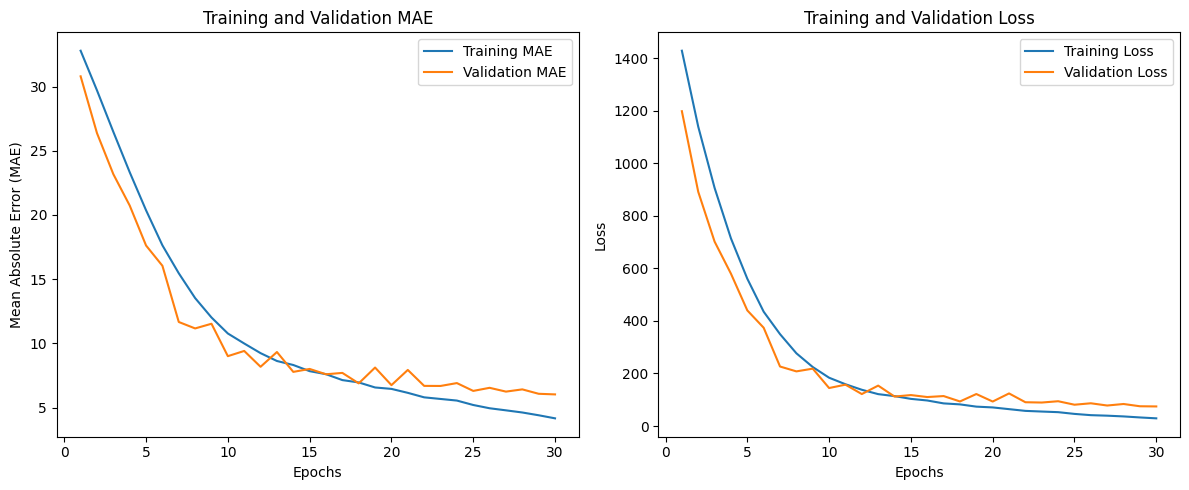

In [11]:
from utils.preprocessing import evaluate_and_plot_regression

# Evaluate and plot the model
evaluate_and_plot_regression(resnet_history)

# Testing the best model

## Testing regression

In [ ]:
from tensorflow.keras.models import load_model

# Define the file path and model name
file_path = '/content/drive/MyDrive/Visual reg/'
model_name = 'resnet50v2_model_finetune_block_5_4.keras'

# Load the model
model = load_model(file_path + model_name)

# Evaluate the model
loss, mae = model.evaluate(X_val, y_val_age, verbose=1)
print(f"Validation Loss (MSE): {loss}")
print(f"Validation MAE: {mae}")

113/113 [==============================] - 44s 379ms/step


In [ ]:
# Predict ages on validation data
y_pred_age = model.predict(X_val).flatten()

113/113 [==============================] - 42s 370ms/step


In [ ]:
import pandas as pd
df_val = pd.DataFrame({
    'y_true_age': y_val_age,
    'y_pred_age': y_pred_age,
    'gender_code': y_val_gender,
    'race_code': y_val_races
})

In [ ]:
# Extract unique mappings for gender and race
gender_mapping = df_utkface_raw[['gender_code', 'gender']].drop_duplicates()
race_mapping = df_utkface_raw[['race_code', 'race']].drop_duplicates()

# Create dictionaries for mapping
gender_dict = dict(zip(gender_mapping['gender_code'], gender_mapping['gender']))
race_dict = dict(zip(race_mapping['race_code'], race_mapping['race']))

# Map codes to labels in the validation DataFrame
df_val['gender'] = df_val['gender_code'].map(gender_dict)
df_val['race'] = df_val['race_code'].map(race_dict)

In [ ]:
# Calculate absolute error
df_val['abs_error'] = abs(df_val['y_true_age'] - df_val['y_pred_age'])

# MAE across genders
gender_mae = df_val.groupby('gender')['abs_error'].mean().reset_index()

# MAE across races
race_mae = df_val.groupby('race')['abs_error'].mean().reset_index()

In [ ]:
gender_mae

,gender,abs_error
0,Female,3.730377
1,Male,3.279155


In [ ]:
race_mae

,race,abs_error
0,Asian,2.990637
1,Black,3.593759
2,Indian,3.194675
3,Others,2.704631
4,White,3.866961


<ipython-input-18-ad8a8bcd15e0>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gender', y='abs_error', data=gender_mae, palette='viridis')


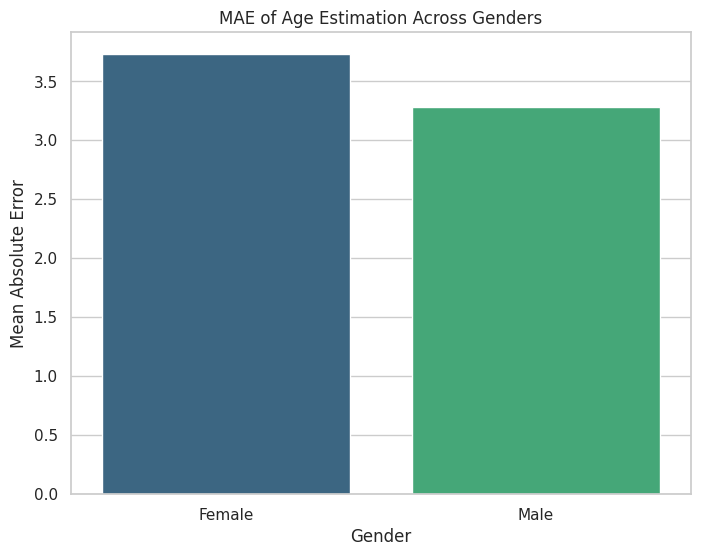

<ipython-input-18-ad8a8bcd15e0>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='race', y='abs_error', data=race_mae, palette='magma')


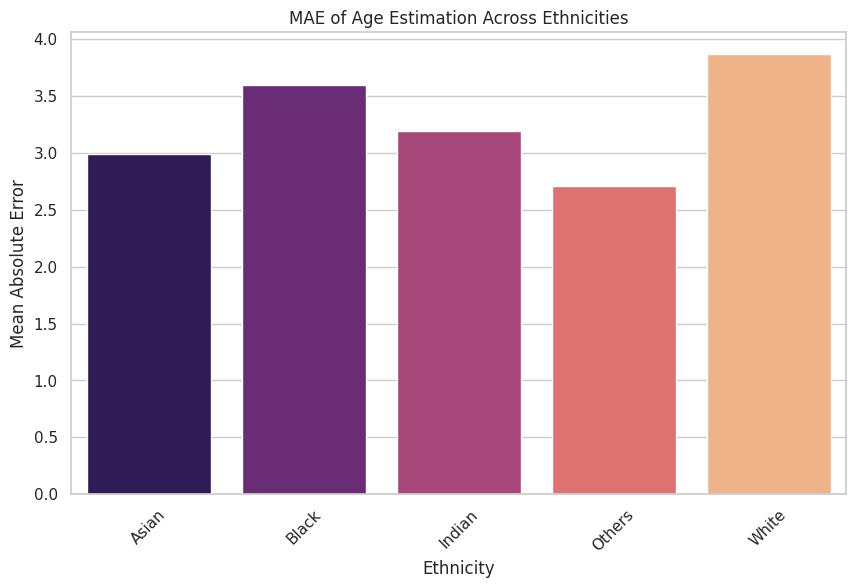

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Plot MAE across genders
plt.figure(figsize=(8,6))
sns.barplot(x='gender', y='abs_error', data=gender_mae, palette='viridis')
plt.title('MAE of Age Estimation Across Genders')
plt.xlabel('Gender')
plt.ylabel('Mean Absolute Error')
plt.show()

# Plot MAE across races
plt.figure(figsize=(10,6))
sns.barplot(x='race', y='abs_error', data=race_mae, palette='magma')
plt.title('MAE of Age Estimation Across Ethnicities')
plt.xlabel('Ethnicity')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.show()

## Testing Age Groups

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Age group boundaries and labels
age_group_bins = [0, 3, 10, 20, 30, 40, 50, 60, 70, 120]  # Use 9 bins for 9 labels
age_group_labels = [
    "0-2 years",
    "3-9 years",
    "10-19 years",
    "20-29 years",
    "30-39 years",
    "40-49 years",
    "50-59 years",
    "60-69 years",
    "70+ years"
]  # Matches bins

# Predict ages
y_pred_age = model.predict(X_val).flatten()  # Ensure predictions are 1D

# Clip ages to ensure valid range
y_pred_age = np.clip(y_pred_age, age_group_bins[0], age_group_bins[-1])
y_val_age = np.clip(y_val_age, age_group_bins[0], age_group_bins[-1])

# Map predictions and ground truth ages to age groups
y_pred_groups = np.digitize(y_pred_age, bins=age_group_bins, right=False) - 1
y_val_groups = np.digitize(y_val_age, bins=age_group_bins, right=False) - 1

113/113 [==============================] - 40s 357ms/step


In [23]:
# Evaluate the classification performance
print("Classification Report:")
print(classification_report(y_val_groups, y_pred_groups, target_names=age_group_labels))

Classification Report:
              precision    recall  f1-score   support

   0-2 years       0.86      0.63      0.73       261
   3-9 years       0.53      0.57      0.55       237
 10-19 years       0.42      0.37      0.40       236
 20-29 years       0.63      0.74      0.68      1121
 30-39 years       0.38      0.37      0.38       683
 40-49 years       0.31      0.33      0.32       331
 50-59 years       0.46      0.41      0.43       341
 60-69 years       0.38      0.33      0.36       189
   70+ years       0.79      0.61      0.69       213

    accuracy                           0.53      3612
   macro avg       0.53      0.48      0.50      3612
weighted avg       0.53      0.53      0.53      3612



In [24]:
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_val_groups, y_pred_groups)
print(conf_matrix)


Confusion Matrix:
[[164  90   4   1   1   0   1   0   0]
 [ 26 135  47  21   2   3   2   1   0]
 [  0  30  88 104  10   3   0   0   1]
 [  0   2  56 831 201  24   6   1   0]
 [  1   0  11 299 254  95  21   2   0]
 [  0   0   2  41 126 109  47   6   0]
 [  0   0   0  12  48  92 139  39  11]
 [  0   0   0   5  16  25  58  63  22]
 [  0   0   0   1   2   4  25  52 129]]


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd
df_val = pd.DataFrame({
    'y_true_age': y_val_age,
    'y_pred_age': y_pred_age,
    'gender_code': y_val_gender,
    'race_code': y_val_races
})

# Extract unique mappings for gender and race
gender_mapping = df_utkface_raw[['gender_code', 'gender']].drop_duplicates()
race_mapping = df_utkface_raw[['race_code', 'race']].drop_duplicates()

# Create dictionaries for mapping
gender_dict = dict(zip(gender_mapping['gender_code'], gender_mapping['gender']))
race_dict = dict(zip(race_mapping['race_code'], race_mapping['race']))

# Map codes to labels
df_val['gender'] = df_val['gender_code'].map(gender_dict)
df_val['race'] = df_val['race_code'].map(race_dict)

# Add age group mappings
df_val['y_true_group'] = np.digitize(df_val['y_true_age'], bins=age_group_bins, right=False) - 1
df_val['y_pred_group'] = np.digitize(df_val['y_pred_age'], bins=age_group_bins, right=False) - 1

# Ensure the groups fall within valid range
df_val['y_true_group'] = np.clip(df_val['y_true_group'], 0, len(age_group_labels) - 1)
df_val['y_pred_group'] = np.clip(df_val['y_pred_group'], 0, len(age_group_labels) - 1)

# Function to evaluate metrics for a specific subset
def evaluate_subset(subset_df, group_label):
    print(f"\nPerformance for {group_label}:\n")
    report = classification_report(
        subset_df['y_true_group'],
        subset_df['y_pred_group'],
        target_names=age_group_labels,
        zero_division=0
    )
    print(report)

# Evaluate metrics by gender
for gender in df_val['gender'].unique():
    subset = df_val[df_val['gender'] == gender]
    evaluate_subset(subset, f"Gender: {gender}")

# Evaluate metrics by ethnicity
for race in df_val['race'].unique():
    subset = df_val[df_val['race'] == race]
    evaluate_subset(subset, f"Race: {race}")


Performance for Gender: Male:

              precision    recall  f1-score   support

   0-2 years       0.92      0.62      0.74       151
   3-9 years       0.46      0.62      0.53        96
 10-19 years       0.45      0.32      0.38       108
 20-29 years       0.60      0.65      0.62       451
 30-39 years       0.39      0.45      0.42       348
 40-49 years       0.36      0.39      0.38       233
 50-59 years       0.51      0.44      0.47       248
 60-69 years       0.37      0.37      0.37       114
   70+ years       0.72      0.51      0.60       113

    accuracy                           0.50      1862
   macro avg       0.53      0.49      0.50      1862
weighted avg       0.52      0.50      0.51      1862


Performance for Gender: Female:

              precision    recall  f1-score   support

   0-2 years       0.79      0.64      0.70       110
   3-9 years       0.60      0.53      0.56       141
 10-19 years       0.40      0.41      0.41       128
 20-29 years